# Test Env + Model

In [11]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

import math
from typing import List, Tuple, Optional, NamedTuple, Dict, Union, Any
from einops import rearrange, repeat
from hydra.utils import instantiate

import torch
from torch import nn
from torch.utils.checkpoint import checkpoint
from torch.nn import DataParallel
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning as L

from torchrl.envs import EnvBase
from torchrl.envs.utils import step_mdp
from tensordict import TensorDict

from rl4co.data.dataset import TensorDictDataset
from rl4co.models.rl.reinforce import *
from rl4co.models.zoo.am.context import env_context
from rl4co.models.zoo.am.embeddings import env_init_embedding, env_dynamic_embedding
from rl4co.models.zoo.am.encoder import GraphAttentionEncoder
from rl4co.models.zoo.am.decoder import Decoder, decode_probs, PrecomputedCache, LogitAttention
from rl4co.models.zoo.am.policy import get_log_likelihood
from rl4co.models.zoo.am import AttentionModel, AttentionModelPolicy
from rl4co.models.nn.attention import NativeFlashMHA, flash_attn_wrapper
from rl4co.utils.lightning import get_lightning_device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import env and dummy pass on the model

In [28]:
from rl4co.envs.tsp import TSPEnv

num_loc = 20
env = TSPEnv(num_loc=num_loc)
device = "cuda" if torch.cuda.is_available() else "cpu"

# env = TSPEnv(num_loc=15).transform()
dataset = env.dataset(batch_size=[1000])

dataloader = DataLoader(
                dataset,
                batch_size=32,
                shuffle=False, # no need to shuffle, we're resampling every epoch
                num_workers=0,
                collate_fn=torch.stack, # we need this to stack the batches in the dataset
            )

policy = AttentionModelPolicy(
    env,
    embedding_dim=128,
    hidden_dim=128,
    n_encode_layers=3,
).to(device)

x = next(iter(dataloader)).to(device)
td = env.reset(init_obs=x)

out = policy(td, decode_type="sampling", return_actions=True)
print(out)

{'reward': tensor([-10.6660, -10.3054,  -9.3820,  -9.6617,  -8.3528,  -9.6192,  -9.8520,
        -10.6383, -11.1463, -11.8132,  -9.5700, -11.3963,  -8.7010, -12.2846,
         -9.5627, -10.6065, -11.0599,  -8.4929,  -9.1204,  -9.9926, -10.0498,
         -9.9968,  -9.7448, -10.7409,  -9.7653, -11.4818,  -9.2803, -12.3139,
         -9.3981,  -8.7240,  -9.1357, -11.8620], device='cuda:0'), 'log_likelihood': tensor([-42.6187, -40.0522, -40.5862, -37.2295, -40.1864, -38.9113, -39.5529,
        -41.7314, -40.0943, -40.2317, -40.6876, -39.9723, -38.3829, -37.9406,
        -38.5394, -42.8395, -40.6009, -43.4773, -39.5137, -40.5977, -41.7279,
        -37.4135, -41.6474, -38.5575, -37.2626, -42.0697, -39.7954, -37.0911,
        -38.9476, -41.3809, -44.1075, -40.4777], device='cuda:0',
       grad_fn=<SumBackward1>), 'actions': tensor([[12,  9, 18, 11, 14,  7,  8, 19, 17,  1,  4, 15,  6,  5,  2, 16,  3, 13,
         10,  0],
        [19,  5,  4, 16,  8, 15, 10,  0, 12,  1,  6, 14,  3, 17,  2, 13,

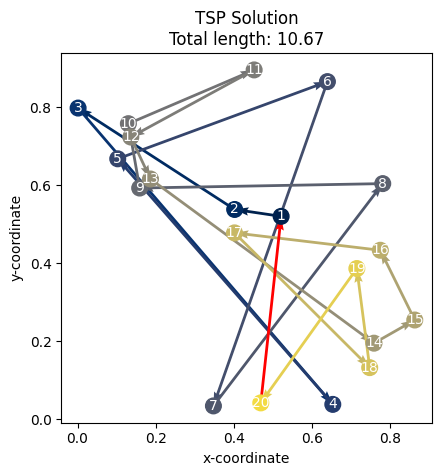

In [29]:
render_td = td.clone()
render_td.set("action", out["actions"])
reward = env.get_reward(render_td, out["actions"])
render_td.set("reward", reward)
env.render(render_td)

## Lightning Module

In [36]:
class NCOLightningModule(L.LightningModule):
    def __init__(self, env, model, lr=1e-4, batch_size=128, train_size=1000, val_size=10000):
        super().__init__()

        # TODO: hydra instantiation
        self.env = env
        self.model = model
        self.lr = lr
        self.batch_size = batch_size
        self.train_size = train_size
        self.val_size = val_size

    def setup(self, stage="fit"):
        self.train_dataset = self.get_observation_dataset(self.train_size)
        self.val_dataset = self.get_observation_dataset(self.val_size)
        if hasattr(self.model, "setup"):
            self.model.setup(self)

    def shared_step(self, batch: Any, batch_idx: int, phase: str):
        td = self.env.reset(init_obs=batch)
        output = self.model(td, phase)
        self.log(f"{phase}/cost", -output["reward"].mean(), prog_bar=True)
        return {"loss": output['loss'] if phase == "train" else None}

    def training_step(self, batch: Any, batch_idx: int):   
        return self.shared_step(batch, batch_idx, phase='train')

    def validation_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase='val')

    def test_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase='test')

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)
        # optim = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
        # TODO: scheduler
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_steps)
        return [optim] #, [scheduler]
    
    def train_dataloader(self):
        return self._dataloader(self.train_dataset)
    
    def val_dataloader(self):
        return self._dataloader(self.val_dataset)
    
    def on_train_epoch_end(self):
        if hasattr(self.model, "on_train_epoch_end"):
            self.model.on_train_epoch_end(self)
        self.train_dataset = self.get_observation_dataset(self.train_size)

    def get_observation_dataset(self, size):
        # online data generation: we generate a new batch online
        # data = self.env.gen_params(batch_size=size)
        return TensorDictDataset(self.env.reset(batch_size=[size])['observation'])
       
    def _dataloader(self, dataset):
        return DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=False, # no need to shuffle, we're resampling every epoch
            num_workers=0,
            collate_fn=torch.stack, # we need this to stack the batches in the dataset
        )

## Test training

In [37]:
batch_size = 128 #1024 #512
epochs = 1
lr = 1e-4
train_size = 1280000

# Instantiate full model
model = AttentionModel(env, policy)

# Lightning module
litmodel = NCOLightningModule(env, model, batch_size=batch_size, train_size=train_size, lr=lr)

# Trick to make calculations faster
torch.set_float32_matmul_precision("medium")


# Trainer
trainer = L.Trainer(
    max_epochs=epochs,
    accelerator="gpu",
    log_every_n_steps=100,   
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
# Fit the model
trainer.fit(litmodel)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | env   | TSPEnv         | 0     
1 | model | AttentionModel | 1.4 M 
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)


Epoch 0:   3%|▎         | 258/10000 [00:07<04:35, 35.37it/s, v_num=5, train/cost=4.380]